## Ноутбук с симуляцией ATL

Импорты:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import os
# import cupy as cp
from PIL import Image, ImageDraw
from pyffs import ffsn, iffsn, ffs_shift, iffs_shift

import pint
u = pint.UnitRegistry()
MAX_INTENS = 256

In [130]:
# a = np.array([[[1, 2, 3, 4], [5, 6, 7, 8], [1, 2, 3, 4], [5, 6, 7, 8]]])
a = np.random.rand(2, 4, 4)
T = [1, 1]
T_c = [0, 0]
N_FS = [3, 3]
f1 = iffsn(a, T, T_c, N_FS, axes=[1, 2])
f2 = []
for i in range(2):
    f2.append(iffsn(a[i], T, T_c, N_FS))
f2 = np.array(f2)
(f2 == f1).all()

True

### Функция, считающая картину на определенном расстоянии по фотке маски

пока что только для монохроматического пучка (просто саморепродукция)

In [2]:
def my_matmul(a, m):
    if np.isscalar(a):
        return a * m
    else:
        return np.outer(a, m).reshape(len(a), m.shape[0], m.shape[1])
    
def compute_carpet(mask, wavelength, T_x, T_y, z, gpu=False):
    '''
    Функция для вычисления дифракционной картины ATL
    param mask: изображение маски,
    param period: период маски, [ед.], 
    param wavelength: длина волны, [ед.]
    param z: расстояние от картины до маски, [1000 * ед.]

    return: изображение картины
    '''
    if gpu:
        mask_array = cp.array(np.sqrt(np.array(mask)))
    else:
        mask_array = np.sqrt(np.array(mask))
    
    N = mask_array.shape[0]
    n = (N - 1) // 2

    T = np.array([float(T_x / u.mm), float(T_y / u.mm)])
    # T = [1, 1]
    #T_c = [0, 0]
    T_c = T / 2
    N_FS = [N, N]
    
    #F = ffs_shift(ffsn(ffs_shift(mask_array), T, T_c, N_FS))
    F = ffsn((mask_array), T, T_c, N_FS)
    print(F.shape)
    f_x = np.reshape(np.arange(-n, n + 1) / T[0], (1, -1))
    f_y = np.reshape(np.arange(-n, n + 1) / T[1], (-1, 1))

    z = float(z / u.mm)
    wavelength = np.array(wavelength / u.mm)

    # H = np.exp(-1j * np.pi * z * my_matmul(wavelength, (np.power(f_x, 2) + np.power(f_y, 2))))
    H = np.exp(-1j * np.pi * z * my_matmul(wavelength, (np.power(f_x, 2) + np.power(f_y, 2))))
    # n_wl = len(wavelength)
    result_array = (iffsn((F * H), T, T_c, N_FS, axes=[1, 2]))
    # result_array = fs_interpn(F * H, T, - T_c , T_c, [512, 512], axes=[1, 2])
    return np.square(np.absolute(result_array))

### Удобные функции для визуализации результата

In [8]:
def periodic_image(arr, reps):
    pic = np.tile(arr, (reps, reps))
    return Image.fromarray(pic)

def frame_plot(arr, ax):
    # ax.figure(figsize=(6, 6))
    rectX = np.linspace(0, 1, arr.shape[0])
    rectY = np.linspace(0, 1, arr.shape[1])
    x, y = np.meshgrid(rectX, rectY)
    ax.pcolormesh(x, y, arr)
    # ax.set_title(f'$\lambda = {wl}$')
    # ax.set_xlabel(f'x, {T_x.units}')
    # ax.set_ylabel(f'y, {T_y.units}')
    # ax.show()

Пробуем функцию на примере кружка

(513, 513)


C:\Users\ACER\AppData\Local\Temp\ipykernel_20416\1640465932.py:35: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  wavelength = np.array(wavelength / u.mm)


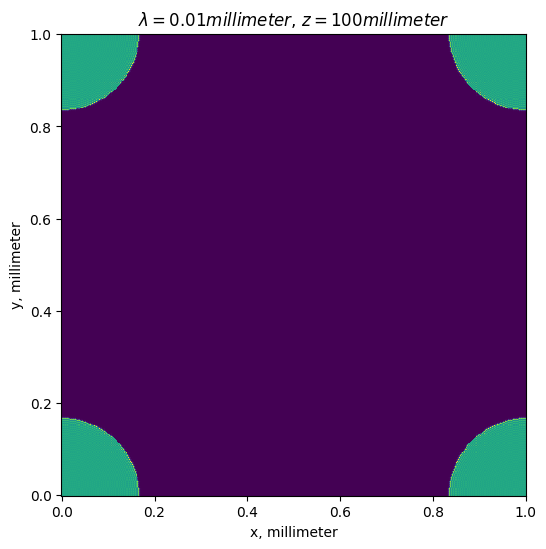

In [191]:
mask = Image.open("grayscale_circle.png").convert("L")
period = 1 * u.mm
wavelength = np.array([0.01]) * u.mm
z = 100 * u.mm
result = compute_carpet(mask, wavelength, period, period, z)
# print(result.shape)
frame_plot(result[0], wavelength[0], period, period, z)
# frame_plot(result[1], wavelength[1], period, period, z)
# periodic_image(result, 5).show()

In [3]:
def compute_atl(mask, T_x, T_y, wl, delta_wl):
    # freq = u.speed_of_light / wl
    # delta_freq = delta_wl * freq / wl
    grid_size = 1000
    wl_grid = np.linspace(wl - delta_wl, wl + delta_wl, grid_size)
    # wl_grid = np.linspace((wl - delta_wl).magnitude, (wl + delta_wl).magnitude, grid_size) * (wl - delta_wl).units
    freq_grid = u.speed_of_light / wl_grid
    delta_freq = freq_grid[1] - freq_grid[0]
    intens = sps.norm.pdf(np.linspace(-2, 2, grid_size))# * MAX_INTENS
    z_A = 2 * max(T_x, T_y) ** 2 / delta_wl
    carp = compute_carpet(mask, wl_grid, T_x, T_y, 2 * z_A) * delta_freq # / MAX_INTENS
    # print(carp.shape)
    return np.average(carp, axis=0, weights=intens)


In [4]:
mask = Image.open("grayscale_circle.png").convert("L")
wl = 13.5 * u.nm
d_wl = 0.04 * wl
p = 1 * u.um
result = compute_atl(mask, p, 1.5 * p, wl, d_wl)

(513, 513)


C:\Users\ACER\AppData\Local\Temp\ipykernel_14456\1640465932.py:35: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  wavelength = np.array(wavelength / u.mm)


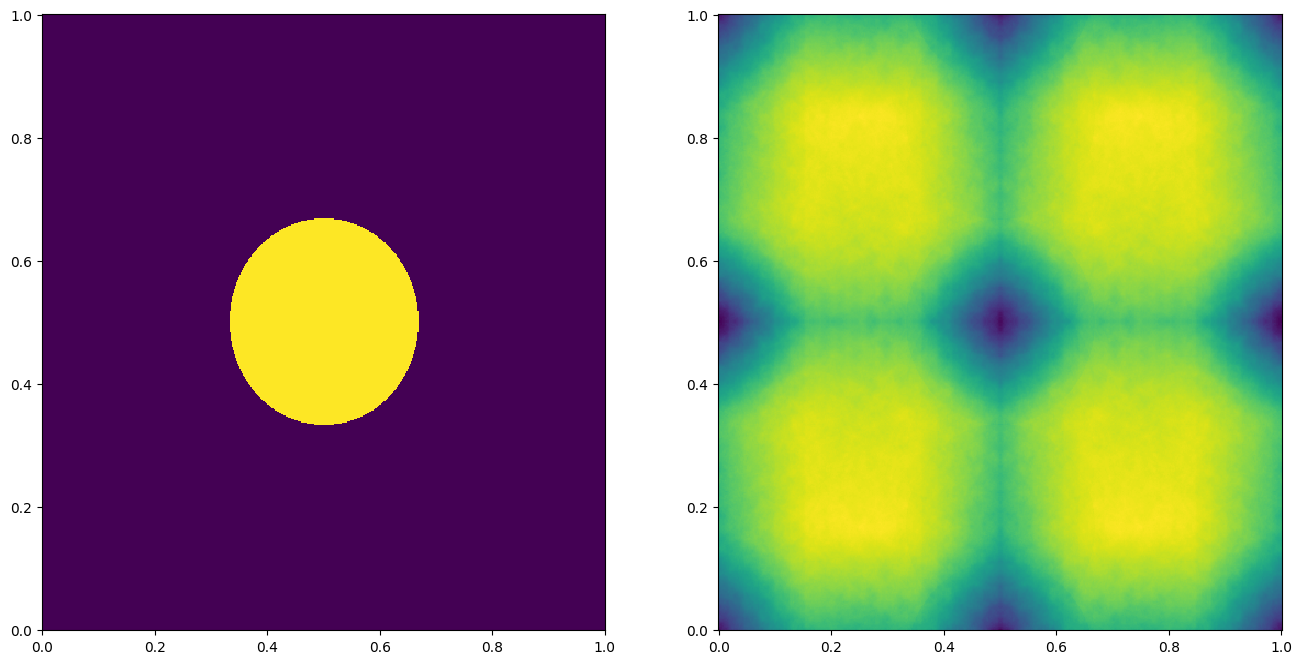

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
frame_plot(result, ax=ax[1])
frame_plot(np.array(mask), ax=ax[0])
# fig.savefig('success.png')